In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import (
    local_binary_pattern,
    graycomatrix,
    graycoprops,
    hog
)
from sklearn.decomposition import PCA
import pywt
import tqdm 

In [2]:
metadata_df = pd.read_csv('../datasets/ISIC_2019_cleaned_cropped_resized/resampled_metadata_resized.csv')

In [ ]:
# --- Parameters ---
LBP_POINTS = 24
LBP_RADIUS = 3
GLCM_DISTANCES = [1, 2, 3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPS = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

# --- Image loading ---
def load_image(image_path, size=(450, 450)):
    img = imread(image_path)
    if img.ndim == 2:  # grayscale
        img = np.stack([img]*3, axis=-1)
    img = resize(img, size, anti_aliasing=True)
    return img

# --- HOG ---
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=4):
    gray = rgb2gray(image)
    features = hog(gray,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   feature_vector=True)
    return features

# --- LBP ---
def extract_lbp_features(image):
    gray = rgb2gray(image)
    lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='default')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), density=True)
    return hist

# --- Color Histograms (HSV) ---
def extract_color_histogram(image, bins=32):
    hsv = rgb2hsv(image)
    h_hist = np.histogram(hsv[:, :, 0], bins=bins, range=(0, 1), density=True)[0]
    s_hist = np.histogram(hsv[:, :, 1], bins=bins, range=(0, 1), density=True)[0]
    v_hist = np.histogram(hsv[:, :, 2], bins=bins, range=(0, 1), density=True)[0]
    return np.concatenate([h_hist, s_hist, v_hist])

# --- GLCM ---
def extract_glcm_features(image):
    gray = (rgb2gray(image) * 255).astype(np.uint8)
    glcm = graycomatrix(gray,
                        distances=GLCM_DISTANCES,
                        angles=GLCM_ANGLES,
                        symmetric=True,
                        normed=True)
    features = []
    for prop in GLCM_PROPS:
        features.extend(graycoprops(glcm, prop).flatten())
    return np.array(features)

# --- Wavelet ---
def extract_wavelet_features(image, wavelet='haar', level=2, max_coeffs=1000):
    gray = rgb2gray(image)
    coeffs = pywt.wavedec2(gray, wavelet=wavelet, level=level)
    coeffs_flat = []
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            for arr in coeff:
                coeffs_flat.extend(arr.ravel())
        else:
            coeffs_flat.extend(coeff.ravel())
    return np.array(coeffs_flat[:max_coeffs])  # cap size

# --- Laplace ---
def extract_laplace_features(image):
    gray = rgb2gray(image)
    laplace = np.abs(cv2.Laplacian(gray, cv2.CV_64F))
    hist, _ = np.histogram(laplace.ravel(), bins=32, range=(0, np.max(laplace)), density=True)
    return hist

# --- PCA utilities ---
def get_PCA(X_list, n_components=2):
    pca_list, xpca_list = [], []
    for X in X_list:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)
    return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15, 5))
    colors = ['b-', 'm-', 'g-', 'r-', 'c-', 'y-']
    labels = ['HOG', 'LBP', 'Color Hist', 'GLCM', 'Wavelet', 'Laplace']
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
    plt.xticks(np.arange(n_components) + 1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variance')
    plt.legend()
    plt.show()

# --- Main feature extraction ---
def extract_all_features(metadata_df, image_base_path):
    hog_list = []
    lbp_list = []
    color_list = []
    glcm_list = []
    wavelet_list = []
    laplace_list = []

    for image_name in tqdm.tqdm(metadata_df['image']):
        image_path = os.path.join(image_base_path, image_name)
        image = load_image(image_path)

        hog_list.append(extract_hog_features(image))
        lbp_list.append(extract_lbp_features(image))
        color_list.append(extract_color_histogram(image))
        glcm_list.append(extract_glcm_features(image))
        wavelet_list.append(extract_wavelet_features(image))
        laplace_list.append(extract_laplace_features(image))

    return {
        'hog': np.array(hog_list),
        'lbp': np.array(lbp_list),
        'color': np.array(color_list),
        'glcm': np.array(glcm_list),
        'wavelet': np.array(wavelet_list),
        'laplace': np.array(laplace_list)
    }

def extract_all_features_batched(metadata_df, image_base_path, batch_size=100, output_dir="features_batches"):
    os.makedirs(output_dir, exist_ok=True)
    num_images = len(metadata_df)
    for start in range(0, num_images, batch_size):
        print(f"Processing batch {start} to {start + batch_size}")
        end = min(start + batch_size, num_images)
        batch_df = metadata_df.iloc[start:end]
        hog_list, lbp_list, color_list, glcm_list, wavelet_list, laplace_list = [], [], [], [], [], []

        for image_name in tqdm.tqdm(batch_df['image']):
            image_path = os.path.join(image_base_path, image_name)
            image = load_image(image_path)
            hog_list.append(extract_hog_features(image))
            lbp_list.append(extract_lbp_features(image))
            color_list.append(extract_color_histogram(image))
            glcm_list.append(extract_glcm_features(image))
            wavelet_list.append(extract_wavelet_features(image))
            laplace_list.append(extract_laplace_features(image))

        # Save each feature type for this batch
        np.save(os.path.join(output_dir, f"hog_{start}_{end}.npy"), np.array(hog_list))
        np.save(os.path.join(output_dir, f"lbp_{start}_{end}.npy"), np.array(lbp_list))
        np.save(os.path.join(output_dir, f"color_{start}_{end}.npy"), np.array(color_list))
        np.save(os.path.join(output_dir, f"glcm_{start}_{end}.npy"), np.array(glcm_list))
        np.save(os.path.join(output_dir, f"wavelet_{start}_{end}.npy"), np.array(wavelet_list))
        np.save(os.path.join(output_dir, f"laplace_{start}_{end}.npy"), np.array(laplace_list))
        print(f"Saved batch {start}-{end}")


In [25]:

extract_all_features_batched(metadata_df, image_base_path="../datasets/ISIC_2019_cleaned_cropped_resized/", batch_size=100)

Processing batch 0 to 100


  0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Saved batch 0-100
Processing batch 100 to 200


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Saved batch 100-200
Processing batch 200 to 300


100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Saved batch 200-300
Processing batch 300 to 400


100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Saved batch 300-400
Processing batch 400 to 500


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Saved batch 400-500
Processing batch 500 to 600


100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Saved batch 500-600
Processing batch 600 to 700


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Saved batch 600-700
Processing batch 700 to 800


100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Saved batch 700-800
Processing batch 800 to 900


100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Saved batch 800-900
Processing batch 900 to 1000


100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Saved batch 900-1000
Processing batch 1000 to 1100


100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Saved batch 1000-1100
Processing batch 1100 to 1200


100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Saved batch 1100-1200
Processing batch 1200 to 1300


100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Saved batch 1200-1300
Processing batch 1300 to 1400


100%|██████████| 100/100 [12:06<00:00,  7.26s/it]


Saved batch 1300-1400
Processing batch 1400 to 1500


100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Saved batch 1400-1500
Processing batch 1500 to 1600


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Saved batch 1500-1600
Processing batch 1600 to 1700


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Saved batch 1600-1700
Processing batch 1700 to 1800


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Saved batch 1700-1800
Processing batch 1800 to 1900


100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Saved batch 1800-1900
Processing batch 1900 to 2000


100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Saved batch 1900-2000
Processing batch 2000 to 2100


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Saved batch 2000-2100
Processing batch 2100 to 2200


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


Saved batch 2100-2200
Processing batch 2200 to 2300


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Saved batch 2200-2300
Processing batch 2300 to 2400


100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Saved batch 2300-2400
Processing batch 2400 to 2500


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Saved batch 2400-2500
Processing batch 2500 to 2600


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


Saved batch 2500-2600
Processing batch 2600 to 2700


100%|██████████| 100/100 [00:13<00:00,  7.58it/s]


Saved batch 2600-2700
Processing batch 2700 to 2800


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


Saved batch 2700-2800
Processing batch 2800 to 2900


100%|██████████| 100/100 [00:13<00:00,  7.50it/s]


Saved batch 2800-2900
Processing batch 2900 to 3000


100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Saved batch 2900-3000
Processing batch 3000 to 3100


100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Saved batch 3000-3100
Processing batch 3100 to 3200


100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


Saved batch 3100-3200
Processing batch 3200 to 3300


100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


Saved batch 3200-3300
Processing batch 3300 to 3400


100%|██████████| 100/100 [00:13<00:00,  7.48it/s]


Saved batch 3300-3400
Processing batch 3400 to 3500


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


Saved batch 3400-3500
Processing batch 3500 to 3600


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Saved batch 3500-3600
Processing batch 3600 to 3700


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Saved batch 3600-3700
Processing batch 3700 to 3800


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Saved batch 3700-3800
Processing batch 3800 to 3900


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Saved batch 3800-3900
Processing batch 3900 to 4000


100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


Saved batch 3900-4000
Processing batch 4000 to 4100


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Saved batch 4000-4100
Processing batch 4100 to 4200


100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


Saved batch 4100-4200
Processing batch 4200 to 4300


100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Saved batch 4200-4300
Processing batch 4300 to 4400


100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Saved batch 4300-4400
Processing batch 4400 to 4500


100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Saved batch 4400-4500
Processing batch 4500 to 4600


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Saved batch 4500-4600
Processing batch 4600 to 4700


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Saved batch 4600-4700
Processing batch 4700 to 4800


100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Saved batch 4700-4800
Processing batch 4800 to 4900


100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Saved batch 4800-4900
Processing batch 4900 to 5000


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Saved batch 4900-5000
Processing batch 5000 to 5100


100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Saved batch 5000-5100
Processing batch 5100 to 5200


100%|██████████| 100/100 [00:13<00:00,  7.54it/s]


Saved batch 5100-5200
Processing batch 5200 to 5300


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


Saved batch 5200-5300
Processing batch 5300 to 5400


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Saved batch 5300-5400
Processing batch 5400 to 5500


100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


Saved batch 5400-5500
Processing batch 5500 to 5600


100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Saved batch 5500-5600
Processing batch 5600 to 5700


100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


Saved batch 5600-5700
Processing batch 5700 to 5800


100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Saved batch 5700-5800
Processing batch 5800 to 5900


100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


Saved batch 5800-5900
Processing batch 5900 to 6000


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


Saved batch 5900-6000
Processing batch 6000 to 6100


100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


Saved batch 6000-6100
Processing batch 6100 to 6200


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Saved batch 6100-6200
Processing batch 6200 to 6300


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Saved batch 6200-6300
Processing batch 6300 to 6400


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Saved batch 6300-6400
Processing batch 6400 to 6500


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Saved batch 6400-6500
Processing batch 6500 to 6600


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Saved batch 6500-6600
Processing batch 6600 to 6700


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Saved batch 6600-6700
Processing batch 6700 to 6800


100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Saved batch 6700-6800
Processing batch 6800 to 6900


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Saved batch 6800-6900
Processing batch 6900 to 7000


100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Saved batch 6900-7000
Processing batch 7000 to 7100


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Saved batch 7000-7100
Processing batch 7100 to 7200


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Saved batch 7100-7200
Processing batch 7200 to 7300


100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Saved batch 7200-7300
Processing batch 7300 to 7400


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Saved batch 7300-7400
Processing batch 7400 to 7500


100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Saved batch 7400-7500
Processing batch 7500 to 7600


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Saved batch 7500-7600
Processing batch 7600 to 7700


100%|██████████| 100/100 [00:15<00:00,  6.55it/s]


Saved batch 7600-7700
Processing batch 7700 to 7800


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Saved batch 7700-7800
Processing batch 7800 to 7900


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Saved batch 7800-7900
Processing batch 7900 to 8000


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

Saved batch 7900-8000


In [26]:
import glob 

In [ ]:
def load_and_concatenate_features(output_dir="features_batches"):
    feature_types = ['hog', 'lbp', 'color', 'glcm', 'wavelet', 'laplace']
    features = {}
    for ft in feature_types:
        # Find all batch files for this feature type
        files = sorted(glob.glob(os.path.join(output_dir, f"{ft}_*.npy")))
        arrays = [np.load(f) for f in files]
        features[ft] = np.concatenate(arrays, axis=0)
        print(f"{ft}: loaded {len(files)} batches, shape {features[ft].shape}")
    return features

# Usage:
features = load_and_concatenate_features(output_dir="features_batches")

hog: loaded 80 batches, shape (8000, 11664)
lbp: loaded 80 batches, shape (8000, 26)
color: loaded 80 batches, shape (8000, 96)
glcm: loaded 80 batches, shape (8000, 72)
wavelet: loaded 80 batches, shape (8000, 1000)


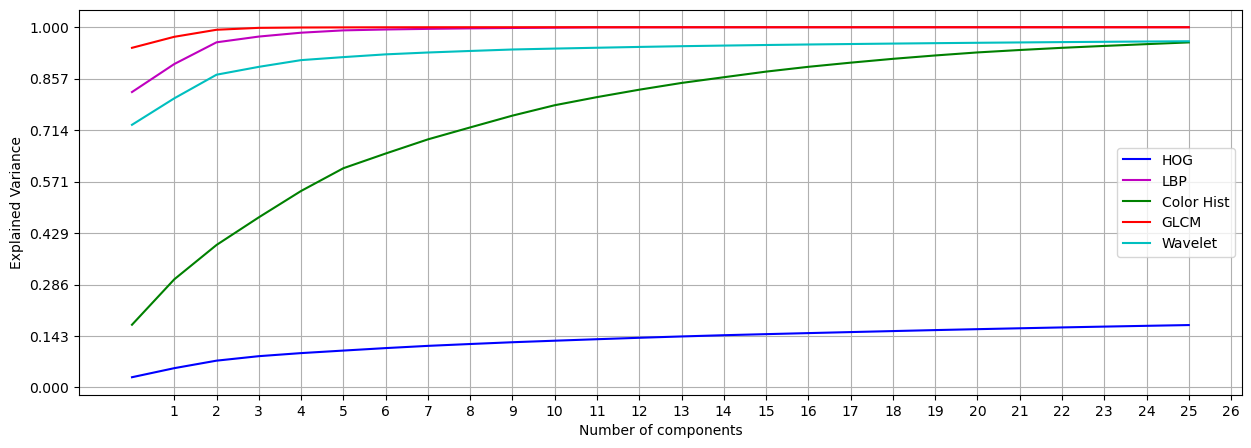

In [28]:
plot_PCA([features['hog'], features['lbp'], features['color'], features['glcm'], features['wavelet']], n_components=26)

In [ ]:
jupyter.viewOutput